In [11]:
import numpy as np
import glob2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import logging
import random
from numba import cuda, float64
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten,Dropout

In [2]:
# logging.basicConfig(filename='./log.log',level=10, filemode = 'w', force=True, format='%(asctime)s   %(funcName)s - %(levelname)s:%(message)s')

# Read data

In [3]:
def read_data(link_cat, link_dog, n_samples, image_size = (128, 128), random_state = 42):
    list_cat = glob2.glob(link_cat)
    list_dog = glob2.glob(link_dog)
    cat_images = []
    cat_labels = []
    for i in range(int(n_samples/2)):
        if 'jpg' in list_cat[i]:
            img = Image.open(list_cat[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                cat_images.append(np.array(img))
                cat_labels.append(1)
    dog_images = []
    dog_labels = []
    for i in range(int(n_samples/2)):
        if 'jpg' in list_dog[i]:
            img = Image.open(list_dog[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                dog_images.append(np.array(img))
                dog_labels.append(-1)
    for index in range(len(cat_images)):
        if cat_images[index].shape[2] != 3:
            print(index, cat_images[index].shape[2])
    for index in range(len(dog_images)):
        if dog_images[index].shape[2] != 3:
            print(index, dog_images[index].shape[2])  
    cat_images = np.array(cat_images)
    cat_labels = np.array(cat_labels)
    dog_images = np.array(dog_images)
    dog_labels = np.array(dog_labels)
    
    x_cat_train, x_cat_test, y_cat_train, y_cat_test = train_test_split(cat_images, cat_labels, test_size=0.3, random_state = random_state)
    x_dog_train, x_dog_test, y_dog_train, y_dog_test = train_test_split(dog_images, dog_labels, test_size=0.3, random_state = random_state)
    X_train = np.concatenate((x_cat_train, x_dog_train), axis = 0)
    y_train = np.concatenate((y_cat_train, y_dog_train), axis = 0)
    X_test = np.concatenate((x_cat_test, x_dog_test), axis = 0)
    y_test = np.concatenate((y_cat_test, y_dog_test), axis = 0)

    s1 = np.arange(X_train.shape[0])
    random.Random(0).shuffle(s1)
    X_train = X_train.take(s1, axis = 0)
    y_train = y_train.take(s1, axis = 0)
    s2  = np.arange(X_test.shape[0])
    random.Random(5).shuffle(s2)
    X_test = X_test.take(s2, axis = 0)
    y_test = y_test.take(s2, axis = 0)
    
    return X_train, y_train, X_test, y_test

# SVM

In [47]:
class SVM_Pa:
    def __init__(self, gamma = -1, kernel = 'rbf', C = 1.0, eps = 1e-3):
        self.C = C
        self.eps = eps
        self.gamma = gamma
        self.tau = 1e-12
        self.kernel = kernel
        self.gamma = gamma
    
    def Kernel(self, x1, x2):
        if self.kernel == 'rbf':
            return self.rbf(x1, x2)
        if self.kernel == 'linear':
            return self.linear(x1, x2)
   
    def linear(self, x1, x2):
        x1_temp = x1.astype(np.float64)
        x2_temp = x2.astype(np.float64)
        return x1_temp.dot(x2_temp)
    
    def rbf(self, x1, x2):
        x1_temp = x1.astype(np.float64)
        x2_temp = x2.astype(np.float64)
        return np.exp(-self.gamma * (x1_temp.dot(x1_temp) + x2_temp.dot(x2_temp) - 2.0 * x1_temp.dot(x2_temp)))
        
    def select_B(self, X):
        i = -1
        G_max = -np.inf
        G_min = np.inf
        for t in range(self.l):
            if (self.y[t] == 1 and self.alphas[t] <self.C) or \
            (self.y[t] == -1 and self.alphas[t] > 0):
                if -self.y[t] * self.G[t] >= G_max:
                    i = t
                    G_max = -self.y[t] * self.G[t]
        j = -1
        obj_min = np.inf
        for t in range(self.l):
            if (self.y[t]==1 and self.alphas[t]>0) or \
                (self.y[t] == -1 and self.alphas[t] < self.C):
                    b = G_max + self.y[t] * self.G[t]
                    if -self.y[t]*self.G[t] <= G_min:
                        G_min = -self.y[t] * self.G[t]
                    if b>0:
                        a = self.Q[i, i] + self.Q[t, t] - 2.0*self.y[i]*self.y[t]*self.Q[i, t]
                        if a<=0:
                            a = self.tau
                        if -(b*b)/a <= obj_min:
                            j = t
                            obj_min = -(b*b)/a
        if G_max - G_min < self.eps:
            return -1, -1
        return i, j

    def predict(self, X):
        return np.sign(self.dual_coef.dot(self.init_K(X)) - self.b)

    @staticmethod
    @cuda.jit 
    def init_K_kernel_rbf(X1, X2, K, n1, n2, m, gamma):
        i, j = cuda.grid(2)
        if i>= n1 or j >= n2:
            return
        sumii = float64(0)
        sumij = float64(0)
        sumjj = float64(0)
        for k in range(m):
            sumii += X1[i][k] * X1[i][k]
            sumij += X1[i][k] * X2[j][k]
            sumjj += X2[j][k] * X2[j][k]
        K[i, j] = math.exp(-gamma * (sumii + sumjj - 2.0 * sumij))
    
    @staticmethod
    @cuda.jit 
    def init_K_kernel_linear(X1, X2, K, n1, n2, m):
        i, j = cuda.grid(2)
        if i>= n1 or j >= n2:
            return
        sumij = float64(0)
        for k in range(m):
            sumij += X1[i][k] * X2[j][k]
        K[i, j] = sumij
        
    def init_K(self, x):
        d_x1 = self.X.astype(np.float64)
        d_x2 = x.astype(np.float64)
        d_K = cuda.device_array((self.l, x.shape[0]), np.float64)
        blocksize = (32, 32)
        print('init_K')
        gridsize = (math.ceil(self.l/blocksize[0]), math.ceil(x.shape[0]/blocksize[1]))
        if self.kernel == 'rbf':
            self.init_K_kernel_rbf[gridsize, blocksize](d_x1, d_x2, d_K, self.l, x.shape[0], self.n_features, self.gamma)
        elif self.kernel == 'linear':
            self.init_K_kernel_linear[gridsize, blocksize](d_x1, d_x2, d_K, self.l, x.shape[0], self.n_features)
        return np.array(d_K.copy_to_host())

    def get_b(self):
        sum = 0.0
        count = 0
        for i in range(self.l):
            if 0 < self.alphas[i] < self.C:
                count += 1
                sum += self.y[i] * self.G[i]
        if count > 0:
            self.b = sum/count
            return
        max = -np.inf
        min = np.inf
        for i in range(self.l):
            if (self.alphas[i] == 0 and self.y[i] == -1) or \
                (self.alphas[i] == self.C and self.y[i] == 1):
                    if max < self.y[i] * self.G[i]:
                        max = self.y[i] * self.G[i]
            if (self.alphas[i] == 0 and self.y[i] == 1) or \
                (self.alphas[i] == self.C and self.y[i] == -1):
                    if min > self.y[i] *self.G[i]:
                        min = self.y[i] * self.G[i]
        self.b = (min+max) / 2
    
    @staticmethod
    @cuda.jit 
    def init_Q_kernel_rbf(X, y, Q, n, m, gamma):
        i, j = cuda.grid(2)
        if i>= n or j >= n:
            return
        sumii = float64(0)
        sumij = float64(0)
        sumjj = float64(0)
        for k in range(m):
            sumii += X[i][k] * X[i][k]
            sumij += X[i][k] * X[j][k]
            sumjj += X[j][k] * X[j][k]
        Q[i, j] = y[i]*y[j]*math.exp(-gamma * (sumii + sumjj - 2.0 * sumij))
    
    
    @staticmethod
    @cuda.jit 
    def init_Q_kernel_linear(X, y, Q, n, m):
        i, j = cuda.grid(2)
        if i>= n or j >= n:
            return
        sumij = float64(0)
        for k in range(m):
            sumij += X[i][k] * X[j][k]
        Q[i, j] = y[i]*y[j]*sumij
        
    def init_Q(self):
        d_x = self.X.astype(np.float64)
        d_y = self.y.astype(np.float64)
        d_Q = cuda.device_array((self.l, self.l), np.float64)
        blocksize = (32, 32)
        gridsize = (math.ceil(self.l/blocksize[0]), math.ceil(self.l/blocksize[1]))
        print('init_Q')
        if self.kernel == 'rbf':
            self.init_Q_kernel_rbf[gridsize, blocksize](d_x, d_y, d_Q, self.l, self.n_features, self.gamma)
        elif self.kernel == 'linear':
            self.init_Q_kernel_linear[gridsize, blocksize](d_x, d_y, d_Q, self.l, self.n_features)
        self.Q = np.array(d_Q.copy_to_host())
    
    @staticmethod
    @cuda.jit
    def compute_dual_coef_kernel(alpha, y, dual_coef, l):
        i = cuda.grid(1)
        if i > l:
            return
        dual_coef[i] = alpha[i] * y[i]

    def compute_dual_coef(self):
        blocksize = 32
        gridsize = math.ceil(self.l/blocksize)
        d_dualcoef = cuda.device_array(self.l, np.float64)
        print('dual_coef')
        self.compute_dual_coef_kernel[gridsize, blocksize](self.alphas, self.y, d_dualcoef, self.l)
        self.dual_coef = d_dualcoef.copy_to_host()
        

    def fit(self, X, y):
        self.y = y
        self.X = X
        self.l, self.n_features = X.shape
        if self.gamma == -1:
            self.gamma = 1/(self.n_features*X.var())
        self.alphas = np.zeros(self.l)
        self.n_iter = 0
        self.init_Q()
        self.G = np.array([-1.0 for _ in range(self.l)])
        while True:
            i, j = self.select_B(X)
            if j == -1:
                break
            self.n_iter += 1
            alphai = self.alphas[i]
            alphaj = self.alphas[j]
            if y[i] != y[j]:
                quad_coef = self.Q[i, i] + self.Q[j, j] + 2*self.Q[i, j]
                if quad_coef <= 0:
                    quad_coef = self.tau
                delta = (-self.G[i] - self.G[j])/quad_coef
                diff = alphai - alphaj
                self.alphas[i] += delta
                self.alphas[j] += delta
                if diff > 0:
                    if self.alphas[j]<0:
                        self.alphas[j] = 0
                        self.alphas[i] = diff
                    if self.alphas[i]>self.C:
                        self.alphas[i] = self.C
                        self.alphas[j] = self.C - diff
                else:
                    if self.alphas[i]<0:
                        self.alphas[i] = 0
                        self.alphas[j] = -diff
                    if self.alphas[j]>self.C:
                        self.alphas[j] = self.C
                        self.alphas[i] = self.C + diff
            else:
                quad_coef = self.Q[i, i] + self.Q[j,j] - 2*self.Q[i,j]
                if quad_coef <=0:
                    quad_coef = self.tau
                delta = (self.G[i]-self.G[j])/quad_coef
                sum = alphai + alphaj
                self.alphas[i] -= delta
                self.alphas[j] += delta
                if sum>self.C:
                    if self.alphas[i]>self.C:
                        self.alphas[i] = self.C
                        self.alphas[j] = sum-self.C
                    if self.alphas[j]>self.C:
                        self.alphas[j] = self.C
                        self.alphas[i] = sum-self.C
                else:
                    if self.alphas[j]<0:
                        self.alphas[j] = 0
                        self.alphas[i] = sum
                    if self.alphas[i]<0:
                        self.alphas[i] = 0
                        self.alphas[j] = sum
            delta_ai = self.alphas[i] - alphai
            delta_aj = self.alphas[j] - alphaj
            self.G += self.Q[i, :] *delta_ai + self.Q[j, :]*delta_aj
        self.compute_dual_coef()
        self.get_b()

# Test 

In [48]:
import HOG_CUDA_2 as CUDA

In [49]:
cell_size = (8, 8)
block_size = (2, 2)
nbins = 9
threadsperblock = (32,32)
hog = CUDA.HOG(block_size, cell_size, nbins, 40,threadsperblock )

In [50]:
def big_fit(X_train, y_train, hog, svm):
    x_train = []
    t = 0
    for x in X_train:
        #print(t, end="  ")
        x_train.append(hog.compute_HOG(x))
        t+=1
    x_train = np.array(x_train)
    svm.fit(x_train, y_train)

def big_predict(X_test, y_test, hog, svm):
    x_test = []
    t = 0
    for x in X_test:
        #print(t, end = "  ")
        x_test.append(hog.compute_HOG(x))
        t+=1
    x_test = np.array(x_test)
    return svm.predict(x_test)

In [42]:
acc5_HOG = []
time5_HOG = []
acc6_HOG = []
time6_HOG = []

In [44]:
n_test = [200]
link_cat = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Cat\**'
link_dog = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Dog\**'

import time
for n in n_test:
    #--------------------------------------------------------------------------------------------
    X_train, y_train, X_test, y_test = read_data(link_cat, link_dog, n)
        
    print("Parallel SVM - rbf",n)
    start = time.time()
    svm = SVM_Pa()
    big_fit(X_train, y_train, hog, svm)
    pred = big_predict(X_test, y_test, hog, svm)
    end = time.time()
    time5_HOG.append(end-start)
    acc5_HOG.append(accuracy_score(pred, y_test))
    
#     print("Parallel SVM - linear",n)
#     start = time.time()
#     svm = SVM_Pa(kernel="linear")
#     big_fit(X_train, y_train, hog, svm)
#     pred = big_predict(X_test, y_test, hog, svm)
#     end = time.time()
#     time6_HOG.append(end-start)
#     acc6_HOG.append(accuracy_score(pred, y_test))
      

Parallel SVM - rbf 200
init_Q
dual_coef


C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


init_K


In [46]:
print(time5_HOG)
acc5_HOG

[1.0820729732513428, 1.0254385471343994]


[0.6, 0.7166666666666667]

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

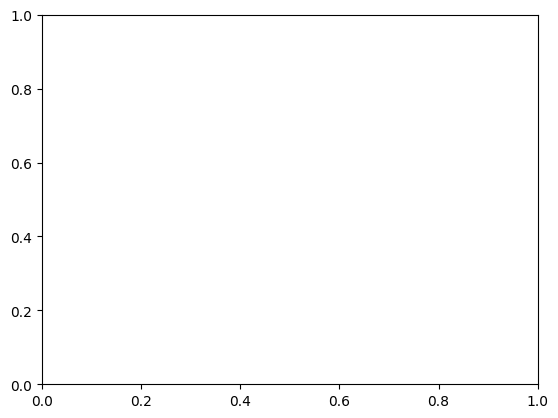

In [37]:
import matplotlib.pyplot as plt
plt.plot(n_test, acc5_HOG, label = 'SVM - rbf')
# plt.plot(n_test, acc6_HOG, label = 'SVM - linear')
plt.title("Accuracy comparison")
plt.legend()
plt.show()

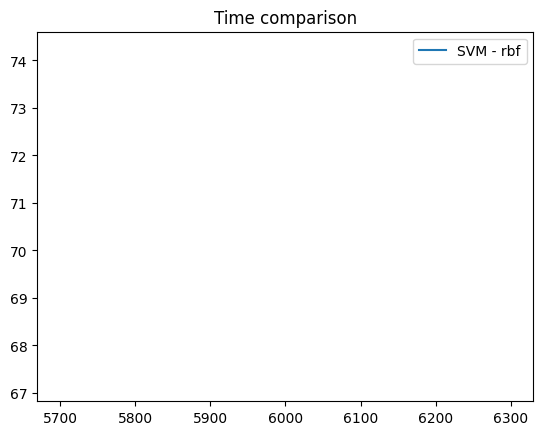

In [19]:
plt.plot(n_test, time5_HOG, label = 'SVM - rbf')
# plt.plot(n_test, time6_HOG, label = 'SVM - linear')
plt.title("Time comparison")
plt.legend()
plt.show()

In [14]:
img = Image.open(r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\cat-1.jpg')

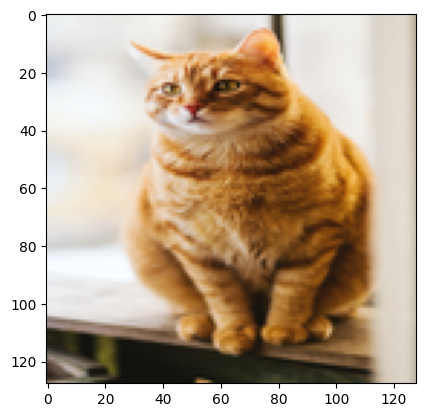

In [17]:
img = img.resize((128, 128), Image.LANCZOS)
pixel = np.array(img)
plt.imshow(pixel)
plt.show()

In [20]:
pred = big_predict(np.array([pixel]), y_test, hog, svm)

C:\ProgramData\Anaconda3\envs\cuda_program\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [21]:
pred

array([1.])

In [22]:
img_2 = Image.open(r"C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Dog\31.jpg")

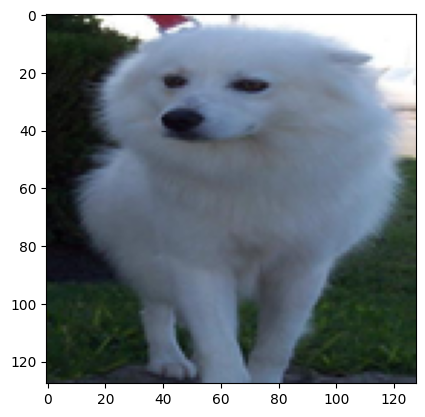

In [23]:
img_2 = img_2.resize((128, 128), Image.LANCZOS)
pixel_2 = np.array(img_2)
plt.imshow(pixel_2)
plt.show()

In [24]:
pred = big_predict(np.array([pixel_2]), y_test, hog, svm)
pred

array([-1.])

In [31]:
img_3 = Image.open(r"C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Cat\143.jpg")

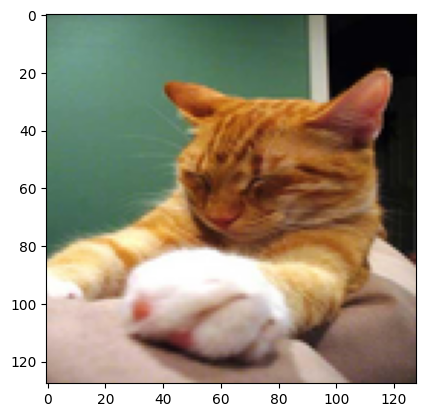

In [32]:
img_3 = img_3.resize((128, 128), Image.LANCZOS)
pixel_3 = np.array(img_3)
plt.imshow(pixel_3)
plt.show()

In [33]:
pred = big_predict(np.array([pixel_3]), y_test, hog, svm)
pred

array([1.])

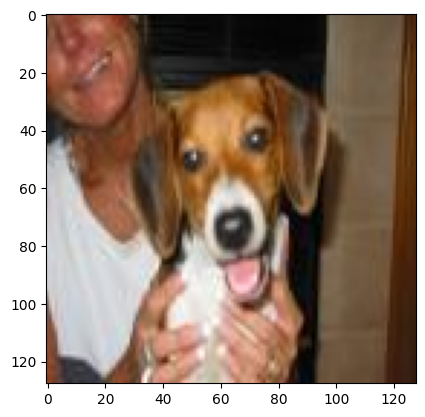

array([-1.])

In [34]:
img_4 = Image.open(r"C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Dog\69.jpg")
img_4 = img_4.resize((128, 128), Image.LANCZOS)
pixel_4 = np.array(img_4)
plt.imshow(pixel_4)
plt.show()
pred = big_predict(np.array([pixel_4]), y_test, hog, svm)
pred

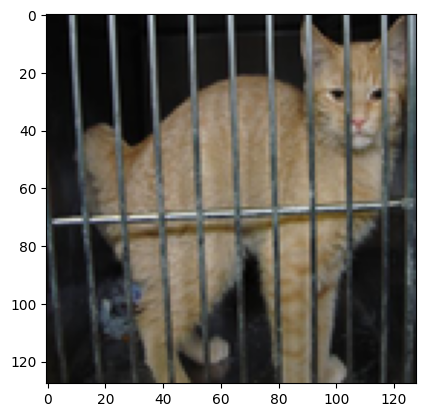

array([-1.])

In [36]:
img_5 = Image.open(r"C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Cat\15.jpg")
img_5 = img_5.resize((128, 128), Image.LANCZOS)
pixel_5 = np.array(img_5)
plt.imshow(pixel_5)
plt.show()
pred = big_predict(np.array([pixel_5]), y_test, hog, svm)
pred

In [25]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = "relu", input_shape = (128,128,3)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 16, kernel_size = (5,5), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units = 256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = "sigmoid"))

In [26]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 64)      4864      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 32)        51232     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 16)       

In [28]:
accu_CNN = []
time_CNN = []

In [64]:
n_test = [4000,6000]
for n in n_test:
    #--------------------------------------------------------------------------------------------
    X_train, y_train, X_test, y_test = read_data(link_cat, link_dog, n)
    if X_train.shape[0] < 400:
        start = time.time()
        model.fit(X_train, y_train, epochs = 20)
        pred = model.predict(X_test)
        end  = time.time()
        pred = pred.round(0).astype(int)
        print(n, end-start,accuracy_score(pred, y_test))
        accu_CNN.append(accuracy_score(pred, y_test))
        time_CNN.append(end-start)
    else:
        X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)
        start = time.time()
        print(X_train.shape,y_train.shape,X_val.shape,y_val.shape)
        model.fit(X_train, y_train,validation_data = (X_val,y_val), epochs = 20)
        pred = model.predict(X_test)
        pred = pred.round(0).astype(int)
        end = time.time()
        print(n, end-start,accuracy_score(pred, y_test))
        accu_CNN.append(accuracy_score(pred, y_test))
        time_CNN.append(end-start)
    

(2240, 128, 128, 3) (2240,) (560, 128, 128, 3) (560,)
Epoch 1/20
70/70 [==============================] - 34s 484ms/step - loss: 0.7278 - accuracy: 0.5335 - val_loss: 0.6906 - val_accuracy: 0.5268
Epoch 2/20
70/70 [==============================] - 34s 485ms/step - loss: 0.6947 - accuracy: 0.5415 - val_loss: 0.6972 - val_accuracy: 0.5304
Epoch 3/20
70/70 [==============================] - 34s 482ms/step - loss: 0.6888 - accuracy: 0.5504 - val_loss: 0.7003 - val_accuracy: 0.5393
Epoch 4/20
70/70 [==============================] - 32s 457ms/step - loss: 0.6771 - accuracy: 0.5580 - val_loss: 0.6987 - val_accuracy: 0.5339
Epoch 5/20
70/70 [==============================] - 32s 457ms/step - loss: 0.6803 - accuracy: 0.5500 - val_loss: 0.6891 - val_accuracy: 0.5500
Epoch 6/20
70/70 [==============================] - 32s 458ms/step - loss: 0.6809 - accuracy: 0.5549 - val_loss: 0.7025 - val_accuracy: 0.5286
Epoch 7/20
70/70 [==============================] - 32s 459ms/step - loss: 0.6774 - accu

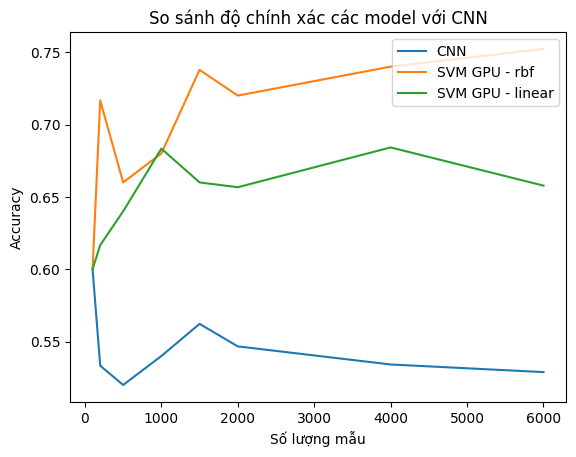

In [65]:
plt.plot([100, 200, 500, 1000, 1500, 2000,4000,6000], accu_CNN , label = 'CNN')
plt.plot([100, 200, 500, 1000, 1500, 2000,4000,6000], acc5_HOG, label = 'SVM GPU - rbf')
plt.plot([100, 200, 500, 1000, 1500, 2000,4000,6000], acc6_HOG, label = 'SVM GPU - linear')
plt.xlabel("Số lượng mẫu")
plt.ylabel("Accuracy")
plt.title("So sánh độ chính xác các model với CNN")
plt.legend()
plt.show()

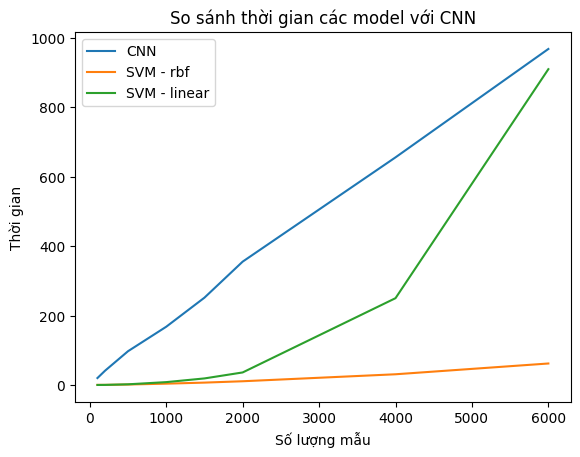

In [67]:
plt.plot([100, 200, 500, 1000, 1500, 2000,4000,6000], time_CNN, label = 'CNN')
plt.plot([100, 200, 500, 1000, 1500, 2000,4000,6000], time5_HOG, label = 'SVM - rbf')
plt.plot([100, 200, 500, 1000, 1500, 2000,4000,6000], time6_HOG, label = 'SVM - linear')
plt.xlabel("Số lượng mẫu")
plt.ylabel("Thời gian")
plt.title("So sánh thời gian các model với CNN")
plt.legend()
plt.show()